## Classification using Autokeras model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob #to walk through folder structure
import seaborn as sns
from PIL import Image #image loading,resize
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak
np.random.seed(42)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.keras.models import load_model

In [3]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')

In [4]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [5]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

In [6]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [7]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [8]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [9]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [10]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [11]:
SIZE=32
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/all_images/', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [13]:
# skin_df_balanced.head()

In [14]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = (X.astype('float32'))/255. # Scale values to 0-1.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing. Get a very small dataset for training as we will be 
# fitting it to many potential models. 

In [15]:
X.shape

(3500, 32, 32, 3)

## Loading Autokeras Model

In [16]:
import autokeras as ak

In [18]:
model = load_model("models/autokeras_model_79acc.h5",custom_objects=ak.CUSTOM_OBJECTS)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        204864    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 64)         0     

## Fitting Model

### Additional Metrics : Top 2 accuracy, Top 3 ccuracy

In [20]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [21]:
x_train.shape

(2625, 32, 32, 3)

In [22]:
x_test.shape

(875, 32, 32, 3)

In [23]:
y_train.shape

(2625, 7)

In [24]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc',top_3_accuracy,top_2_accuracy])


In [27]:

# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 20

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/20
165/165 - 16s - loss: 0.2991 - acc: 0.8983 - top_3_accuracy: 0.9928 - top_2_accuracy: 0.9718 - val_loss: 1.2278 - val_acc: 0.7989 - val_top_3_accuracy: 0.9429 - val_top_2_accuracy: 0.8960 - 16s/epoch - 100ms/step
Epoch 2/20
165/165 - 19s - loss: 0.3170 - acc: 0.8895 - top_3_accuracy: 0.9947 - top_2_accuracy: 0.9749 - val_loss: 1.1072 - val_acc: 0.7874 - val_top_3_accuracy: 0.9371 - val_top_2_accuracy: 0.8891 - 19s/epoch - 114ms/step
Epoch 3/20
165/165 - 19s - loss: 0.3062 - acc: 0.8941 - top_3_accuracy: 0.9924 - top_2_accuracy: 0.9756 - val_loss: 1.0811 - val_acc: 0.7909 - val_top_3_accuracy: 0.9337 - val_top_2_accuracy: 0.8880 - 19s/epoch - 112ms/step
Epoch 4/20
165/165 - 18s - loss: 0.3154 - acc: 0.8964 - top_3_accuracy: 0.9909 - top_2_accuracy: 0.9695 - val_loss: 1.1507 - val_acc: 0.7989 - val_top_3_accuracy: 0.9349 - val_top_2_accuracy: 0.8869 - 18s/epoch - 111ms/step
Epoch 5/20
165/165 - 18s - loss: 0.3348 - acc: 0.8865 - top_3_accuracy: 0.9909 - top_2_accuracy: 0.9741 

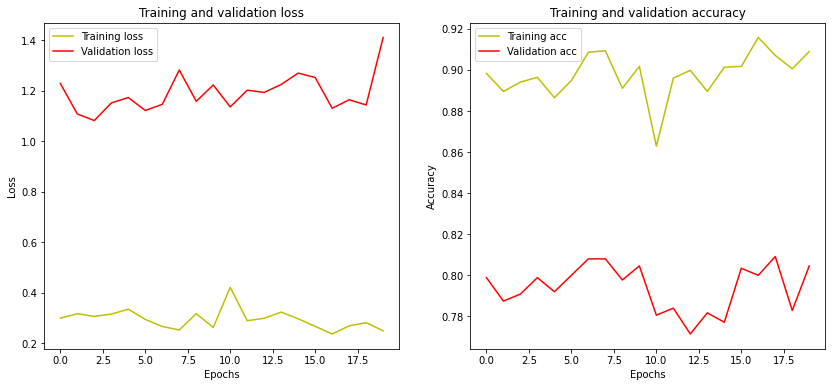

In [28]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(20)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
model.metrics_names

['loss', 'acc', 'top_3_accuracy', 'top_2_accuracy']

In [30]:
val_loss, val_acc, val_top_3_acc, val_top_2_acc = model.evaluate(x_test, y_test)

print('val_loss:', val_loss)
print('val_acc:', val_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

28/28 [==============================] - 1s 37ms/step - loss: 1.4099 - acc: 0.8046 - top_3_accuracy: 0.9406 - top_2_accuracy: 0.8800
val_loss: 1.4099373817443848
val_acc: 0.8045714497566223
val_top_2_acc: 0.8799999952316284
val_top_3_acc: 0.9405714273452759


In [31]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

28/28 [==============================] - 1s 35ms/step


In [32]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)

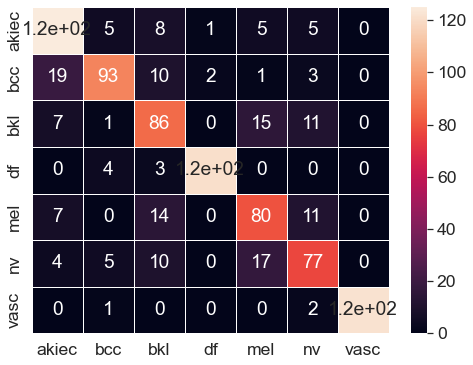

In [56]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
ax.xaxis.set_ticklabels(list(le.classes_))
ax.yaxis.set_ticklabels(list(le.classes_))
fig.show()

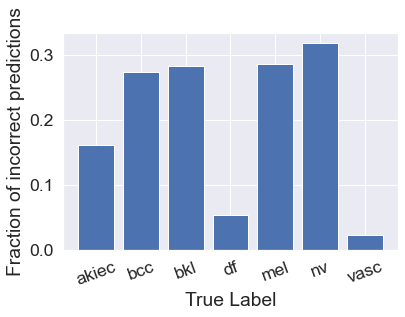

In [34]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks([0,1,2,3,4,5,6], list(le.classes_),rotation=20)
plt.show()

In [107]:
incorr_fraction

array([0.16107383, 0.2734375 , 0.28333333, 0.0546875 , 0.28571429,
       0.31858407, 0.024     ])

In [112]:
percent_classification_error = np.round(incorr_fraction*100,2)

In [113]:
percent_classification_error

array([16.11, 27.34, 28.33,  5.47, 28.57, 31.86,  2.4 ])

In [114]:
le.classes_

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

In [118]:
cancers = ["Actinic Keratosis","Basal cell carcinoma","Benign Keratosis","Dermatofibroma","Melanoma","Melanocytic Nevus","Vascular Lesion"]

In [115]:
from tabulate import tabulate

In [119]:
headers=["Cancer Type","Classification Error %"]
table = zip(cancers,percent_classification_error)
print(tabulate(table, headers=headers, floatfmt=".2f"))

Cancer Type             Classification Error %
--------------------  ------------------------
Actinic Keratosis                        16.11
Basal cell carcinoma                     27.34
Benign Keratosis                         28.33
Dermatofibroma                            5.47
Melanoma                                 28.57
Melanocytic Nevus                        31.86
Vascular Lesion                           2.40


In [35]:
#save model
model.save('skin_lesion_classifier_acc_80.45.h5')

In [52]:
list(le.classes_)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       149
           1       0.85      0.73      0.78       128
           2       0.66      0.72      0.69       120
           3       0.98      0.95      0.96       128
           4       0.68      0.71      0.70       112
           5       0.71      0.68      0.69       113
           6       1.00      0.98      0.99       125

    accuracy                           0.80       875
   macro avg       0.81      0.80      0.80       875
weighted avg       0.81      0.80      0.81       875



In [59]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize

In [60]:
classes = np.unique(y_true)

In [62]:
y_test_binarized = label_binarize(y_true,classes=np.unique(y_true)) #binarising list object

In [63]:
y_test_binarized.shape

(875, 7)

In [65]:
y_test_proba = y_pred

In [71]:
classes = np.array(list(le.classes_))
classes

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype='<U5')

In [72]:
classes.shape

(7,)

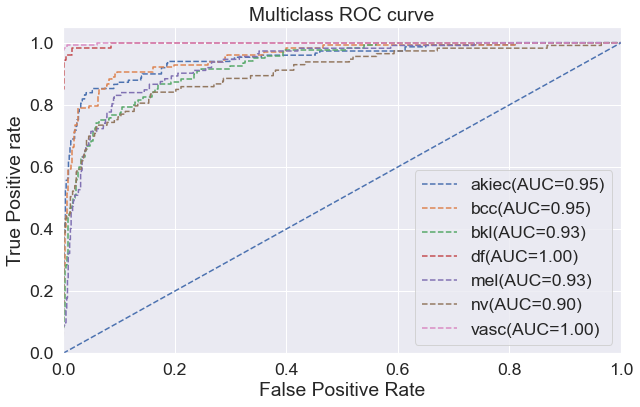

In [73]:
#roc curve for all classes
fpr ={}
tpr={}
thresh ={}
roc_auc=dict()

plt.figure(figsize=(10,6))

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], y_test_proba[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s(AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [95]:
roc_auc_score(y_test_binarized,y_test_proba,multi_class='ovr')

0.9517402242991607

In [74]:
from sklearn.manifold import TSNE

In [76]:
import tensorflow as tf

In [96]:
model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

In [97]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        204864    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 64)         0   

In [98]:
features = model2.predict(x_test)

28/28 [==============================] - 1s 36ms/step


In [99]:
features.shape

(875, 7)

In [104]:
tsne = TSNE(n_components=2).fit_transform(features)

In [105]:
tsne.shape

(875, 2)

In [102]:
labels = np.argmax(model.predict(x_test), axis=1)

28/28 [==============================] - 1s 36ms/step


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


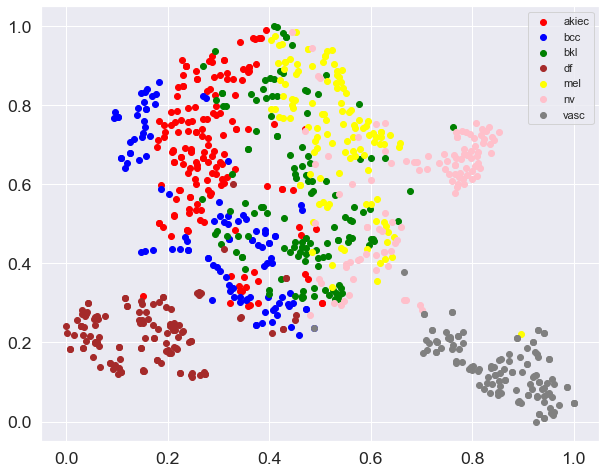

In [106]:
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

colors = ['red', 'blue', 'green', 'brown', 'yellow','pink','grey']
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classes)

fig, ax= plt.subplots(figsize=(10,8))

for idx, c in enumerate(colors):
    index = [i for i, l in enumerate(labels) if idx == l]
    current_tx = np.take(tx, index)
    current_ty = np.take(ty, index)
    ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

ax.legend(loc='best',fontsize = 'xx-small')